In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
from pathlib import Path
import pandas as pd

import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR
from torchvision import models
from torchvision.prototype.models import resnet18, ResNet18_Weights

from matplotlib import pyplot as plt
from torchvision.io import read_image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import fbeta_score

from PIL import Image
import os
import cv2
import numpy as np

/Users/vince/miniconda3/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (5.0.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [3]:
data_dar = "../data/amazon"

In [4]:
train = Path(data_dar) / "train"
classes = Path(data_dar) / "train_v2.csv"
path_train = str(Path(data_dar) / "train")

In [5]:
df_class = pd.read_csv(classes)
df_class[:5]

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [6]:
from collections import Counter
df_class["list_tags"] = df_class.tags.str.split(" ")
row_tags = df_class.list_tags.values
tags = [tag for row in row_tags for tag in row]
counter_tags = Counter(tags)
df_tags = pd.DataFrame(
    {"tag": counter_tags.keys(), "total": counter_tags.values()}
).sort_values("total")

In [7]:
class AmazonDataset(Dataset):
    def __init__(self, df, ohe_tags, transform, path):
        super().__init__()
        self.df = df
        self.ohe_tags = ohe_tags
        self.transform = transform
        self.path = path

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        filename = self.df.iloc[idx].image_name + ".jpg"
        if filename in os.listdir(self.path):
            file_path = os.path.join(self.path, filename)
        else:
            raise Exception(f"Can't fetch {filename} among {self.paths}")
        img = read_image(file_path)
        label = self.ohe_tags[idx]
        img = self.transform(img)
        return img, label

In [8]:
read_image('../data/amazon/train/train_12616.jpg').to('cpu').shape #cmyk

torch.Size([4, 256, 256])

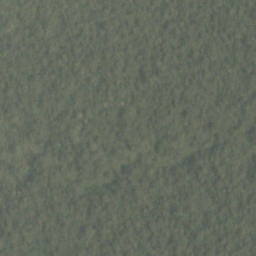

In [9]:
transforms.ToPILImage()(read_image('../data/amazon/train/train_12616.jpg'))

In [33]:
trsfm = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(  
      mean=[0.485, 0.456, 0.406,0.5], 
      std=[0.229, 0.224, 0.225,0.5],
  )
])

In [34]:
device = torch.device("mps")
df_train, df_val = train_test_split(df_class, test_size=.2)

In [35]:
path_train = str(Path(data_dar) / "train")

encoder = MultiLabelBinarizer()
ohe_tags_train = encoder.fit_transform(df_train.list_tags.values)
ohe_tags_val = encoder.transform(df_val.list_tags.values)

ds_train = AmazonDataset(df_train, ohe_tags_train, trsfm, path=path_train)
ds_val = AmazonDataset(df_val, ohe_tags_val, trsfm, path=path_train)

dl_train = DataLoader(
  ds_train,
  batch_size=64*2,
  shuffle=True,
)
dl_val = DataLoader(
  ds_val,
  batch_size=64*2,
  shuffle=True,
)

In [36]:
imgs, labels = next(iter(dl_train))
imgs.shape, labels.shape

(torch.Size([128, 4, 224, 224]), torch.Size([128, 17]))

In [37]:
image, label = imgs[1], labels[1]
image.shape, label.shape

(torch.Size([4, 224, 224]), torch.Size([17]))

In [38]:
label = label.unsqueeze(0).detach().int().cpu().numpy()
label.shape

(1, 17)

In [39]:
encoder.classes_, encoder.classes_.shape

(array(['agriculture', 'artisinal_mine', 'bare_ground', 'blooming',
        'blow_down', 'clear', 'cloudy', 'conventional_mine', 'cultivation',
        'habitation', 'haze', 'partly_cloudy', 'primary', 'road',
        'selective_logging', 'slash_burn', 'water'], dtype=object),
 (17,))

In [40]:
label.shape

(1, 17)

In [41]:
title = encoder.inverse_transform(label)
title

[('clear', 'primary')]

In [42]:
image.permute(1,2,0).cpu().numpy().shape

(224, 224, 4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


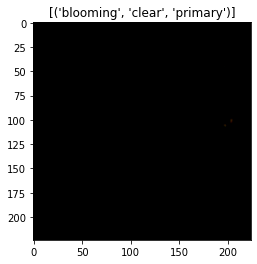

In [32]:
plt.title(title)
plt.imshow(image.permute(1,2,0))

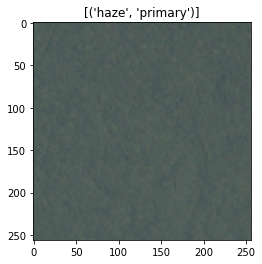

In [20]:
plt.title(title)
plt.imshow(image.permute(1,2,0))

In [43]:
model = models.resnet18(weights=True)
for param in model.parameters():
    param.require_grad = False
model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
model.fc = nn.Sequential(
  nn.Flatten(),
  nn.Linear(512, 128),
  nn.ReLU(inplace=True),
  nn.Dropout(.2),
  nn.Linear(128, 17),
  nn.Sigmoid()
)
optimizer = Adam(model.parameters(), lr=1e-4)
loss_fn = nn.BCELoss()
model = model.to(device)

/Users/vince/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [44]:
df_class.tags.values

array(['haze primary', 'agriculture clear primary water', 'clear primary',
       ..., 'agriculture clear primary', 'agriculture clear primary road',
       'agriculture cultivation partly_cloudy primary'], dtype=object)

In [23]:
def train_batch(X, Y, model, loss_fn, optimizer):
    model.train()
    optimizer.zero_grad()
    Y_hat = model(X)
    batch_loss = loss_fn(Y_hat, Y)
    batch_loss.backward()
    optimizer.step()
    Y_hat = Y_hat.detach().float().cpu().numpy()
    
    return Y_hat, batch_loss.item()


@torch.no_grad()
def compute_val_loss(X, Y, model, loss_fn):
    model.eval()
    Y_hat = model(X)
    batch_loss = loss_fn(Y_hat, Y)
    Y_hat = Y_hat.detach().float().cpu().numpy()
    
    return Y_hat, batch_loss.item()

In [79]:
def train_model(dl_train, dl_val):
    lr_scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

    loss_train, loss_val = [], []
    score_train, score_val = [], []

    Y_hat_val = None
    best_loss_val = np.inf

    epochs = 4
    for idx in range(epochs):
        loss_train_epoch, loss_val_epoch = [], []
        Y_hat_train_epoch, Y_hat_val_epoch = [], []
        Y_train_epoch, Y_val_epoch = [], []

        for X, Y in tqdm(dl_train, leave=False):
            Y_hat, batch_loss = train_batch(X, Y, model, loss_fn, optimizer)
            loss_train_epoch.append(batch_loss)
            Y_hat_train_epoch.extend(Y_hat)
            Y_train_epoch.extend(Y.detach().float().cpu().numpy())

        for X, Y in tqdm(dl_val, leave=False):
            Y_hat, batch_loss = compute_val_loss(X, Y, model, loss_fn)
            loss_val_epoch.append(batch_loss)
            Y_hat_val_epoch.extend(Y_hat)
            Y_val_epoch.extend(Y.detach().float().cpu().numpy())
                
        avg_loss_train = np.mean(loss_train_epoch)
        avg_loss_val = np.mean(loss_val_epoch)

        Y_hat_train_epoch = np.array(Y_hat_train_epoch)
        Y_hat_val_epoch = np.array(Y_hat_val_epoch)
        Y_thresh_train_epoch = (Y_hat_train_epoch > .2).astype(float)
        Y_thresh_val_epoch = (Y_hat_val_epoch > .2).astype(float)
        Y_train_epoch = np.array(Y_train_epoch)
        Y_val_epoch = np.array(Y_val_epoch)
        
        score_train_epoch = fbeta_score(Y_train_epoch, Y_thresh_train_epoch, beta=2, average="samples")
        score_val_epoch = fbeta_score(Y_val_epoch, Y_thresh_val_epoch, beta=2, average="samples")
               
        # saving values for debugging
        if avg_loss_val < best_loss_val:
            best_loss_val = avg_loss_val
            Y_hat_val = Y_hat_val_epoch
            Y_thresh_val = Y_thresh_val_epoch
            Y_val = Y_val_epoch
            
        loss_train.append(avg_loss_train)
        loss_val.append(avg_loss_val)
        score_train.append(score_train_epoch)
        score_val.append(score_val_epoch)

        print(
            f"epoch: {idx}/{epochs} -- train loss: {avg_loss_train}, " \
            f"val loss: {avg_loss_val}" \
            f" -- train fbeta_score: {score_train_epoch}, " \
            f"val fbeta_score: {score_val_epoch}"
        )
        
        lr_scheduler.step()

    train_results = {
        "loss_train": loss_train,
        "loss_val": loss_val,
        "score_train": score_train,
        "score_val": score_val,
        "Y_hat_val": Y_hat_val,
        "Y_thresh_val": Y_thresh_val,
        "Y_val": Y_val,
    }
        
    torch.save(model, f"resnet18_fold.pth")
    pickle.dump(train_results, open(f"train_results_fold.pkl", "wb"))

In [80]:
from tqdm import tqdm

In [81]:
train_model(dl_train, dl_val)

NameError: name 'fbeta_score' is not defined

In [130]:
df_tags

,tag,total
11,conventional_mine,100
16,blow_down,101
8,slash_burn,209
14,blooming,332
13,artisinal_mine,339
15,selective_logging,340
12,bare_ground,862
9,cloudy,2089
0,haze,2697
5,habitation,3660


In [83]:
data, target = next(iter(dl_val))

In [87]:
data[0].shape, target[0].shape

(torch.Size([3, 224, 224]), torch.Size([17]))

In [93]:
data[0].unsqueeze(dim=0).shape

torch.Size([3, 224, 224, 1])

In [190]:
model.eval();
y = model(data[0].unsqueeze(dim=0))

In [195]:
y.detach().float().cpu().numpy().shape

(1, 17)

In [194]:
y.detach().float().cpu().numpy()

array([[0.03433804, 0.00361943, 0.00446245, 0.00642671, 0.00670388,
        0.01850645, 0.13047734, 0.00996605, 0.0132494 , 0.00794614,
        0.8546632 , 0.03177656, 0.90719384, 0.01337356, 0.00217995,
        0.01002635, 0.04301975]], dtype=float32)

In [148]:
encoder.classes_

array(['agriculture', 'artisinal_mine', 'bare_ground', 'blooming',
       'blow_down', 'clear', 'cloudy', 'conventional_mine', 'cultivation',
       'habitation', 'haze', 'partly_cloudy', 'primary', 'road',
       'selective_logging', 'slash_burn', 'water'], dtype=object)

In [151]:
len(encoder.classes_)

17

In [155]:
target[0].detach().int().cpu().numpy()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0], dtype=int32)

In [131]:
df_train.head(2)

,image_name,tags,list_tags
8195,train_8195,clear habitation primary,"[clear, habitation, primary]"
34131,train_34131,agriculture clear habitation primary road,"[agriculture, clear, habitation, primary, road]"


In [132]:
encoder.fit_transform(df_train.head(2).list_tags.values)

array([[0, 1, 1, 1, 0],
       [1, 1, 1, 1, 1]])

In [135]:
encoder.inverse_transform(encoder.fit_transform(df_train.head(2).list_tags.values))

[('clear', 'habitation', 'primary'),
 ('agriculture', 'clear', 'habitation', 'primary', 'road')]

In [177]:
t = encoder.transform(df_val.list_tags.values)

In [179]:
t.shape

(8096, 17)

In [172]:
encoder.transform(df_val.list_tags.values)[0]

array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1])

In [166]:
encoder.transform(df_val.list_tags.values)[0].astype(int)

array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1])

In [184]:
(target[0].unsqueeze(0).detach().int().cpu().numpy()).shape

(1, 17)

In [188]:
target[0].unsqueeze(0).detach().int().cpu().numpy()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]], dtype=int32)

In [187]:
encoder.classes_

array(['agriculture', 'artisinal_mine', 'bare_ground', 'blooming',
       'blow_down', 'clear', 'cloudy', 'conventional_mine', 'cultivation',
       'habitation', 'haze', 'partly_cloudy', 'primary', 'road',
       'selective_logging', 'slash_burn', 'water'], dtype=object)

In [189]:
encoder.inverse_transform(target[0].unsqueeze(0).detach().int().cpu().numpy())

[('haze', 'primary')]

In [199]:
(y.detach().float().cpu().numpy() > 0.7).astype(int)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]])

In [201]:
encoder.inverse_transform((y.detach().float().cpu().numpy() > 0.7).astype(float))

[('haze', 'primary')]

In [20]:
datasets.EuroSAT?

In [22]:
trsfm = transforms.ToTensor()
dataset = datasets.EuroSAT(root='../data/', download=True, transform=trsfm)

  0%|          | 0/94280567 [00:00<?, ?it/s]

Extracting ../data/eurosat/EuroSAT.zip to ../data/eurosat


In [36]:
dataset.class_to_idx

{'AnnualCrop': 0,
 'Forest': 1,
 'HerbaceousVegetation': 2,
 'Highway': 3,
 'Industrial': 4,
 'Pasture': 5,
 'PermanentCrop': 6,
 'Residential': 7,
 'River': 8,
 'SeaLake': 9}

In [24]:
dataloader = DataLoader(dataset=dataset, batch_size=64, shuffle=True)

In [25]:
image, label = next(iter(dataloader))

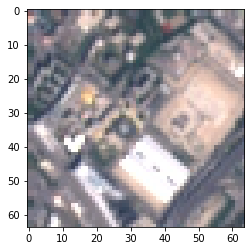

In [41]:
plt.imshow(image[4].permute(1, 2, 0))